# Clasificare Binară folosind SVM

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

from utils import plot_learning_curve

import seaborn as sns; sns.set()

np.random.seed(100)

## AUC ROC

Acesta este de fapt un grafic ce va fi plotat cu scopul de a evalua în ce măsură avem specificitate în modelul nostru, versus sensibilitate.

**Specificitatea** modelului este dată de rata de true positives (adică dacă eu vreau ca modelul să prezică o formă de cancer malign, specificitatea va fi dată de nr de predicții M care sunt și corecte).

**Sensibilitatea** reprezintă cât de mult s-a înșelat modelul din punctul de vedere al sample-urilor pozitive. Adică câte false negatives a dat în faza de test.

AUC - Area Under the Curve
ROC - Receiver Operating Characteristic

Note:
- îmi doresc un AUC cu cât mai mult peste 0.5, ca să pot avea încredere în puterea de predicție a modelului meu.
- AUC ROC îmi dă niște indicii despre acuratețe, da ele nu reprezintă același lucru. Cu alte cuvinte, pentru seturi de date nebalansate (în care am muuulte sample-uri dintr-o clasă și extrem de puține din alta) nu mai pot avea prea mare încredere în acuratețea overall.

Nu trebuie să vă faceți griji dacă nu înțelegeți foarte bine codul acesta de plotare, căci este un helper care ne va ajuta să vizualizăm niște rezultate. Nu influențează cu nimic partea de ML implementată aici. 

In [32]:
# Plot roc curve for a specific class
def plot_roc_curve(fpr, tpr, roc_auc, rc_msg="Test on all\n"):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(rc_msg + 'Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [33]:
def compute_roc_auc(y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    # We are interested in the false positives rate and also the true positive rate
    return fpr, tpr, roc_auc

## Mean & Standard Deviation

Avem aici o funcție care nu face prea multe :)
Primește o listă și un mesaj și printează mesajul însoțit de media aritmetică și deviația standard a valorilor din listă.

Media aritmetică o să presupun că știți cu ce se mănâncă.
Haidem să auzim 3 vorbe despre deviația standard:
- ne dă o idee despre precizia modelului nostru.
- dacă de exemplu noi avem o listă în care fiecare element reprezintă acuratețea obținută în fiecare rundă de test pe date diferite, ne-ar interesa să știm cam la ce distanță au fost acele acurateți. Asta ne zice deviația standard.
- o deviație standard mare, se traduce drept o precizie mai mică.
- vrem ca std dev să fie cât mai mic.

In [34]:
def print_mean(vals_lst, msg):
    print ("-----------------------------------------------------------------------------") 
    print(msg,  np.mean(vals_lst), np.std(vals_lst) )
    print ("-----------------------------------------------------------------------------\n")

## Un pas din SVM

Avem următoarele etape:
1. 
    - 1.1. **Alegem ce parametri vrem să optimizăm.** 
   Noi vom opta pentru **C-value** aici, acesta controlând cât de mult să evite SVM-ul nostru clasificarea greșită a fiecărui exemplu. Pentru valori mici ale lui C, vom avea mai multe exemple clasificate greșit dacă setul nostru de date conține puncte linear separabile (vezi în prezentare ce înseamnă asta). Prin urmare, avem nevoie de căutarea asta de ce valoare este mai nimerită pentru C.
   (https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel)
    - 1.2. **Inițializăm modelul**.
    Aici vom folosi **LinearSVC** din sklearn, pe care l-am importat deja mai sus.
    Ca și unic parametru, vom avea **random_state**=100 (seed-ul folosit de pseudo random number generator-ul folosit când se face shuffle la date).
2. **Inițializăm un obiect de tipul GridSearchCV** 
    acesta va fi în stare să folosească un clasificator custom (în cazul nostru **clf**) și să optimizeze o metrică aleasă (în cazul nostru **accuracy**), iar ca să facă asta o să ne aleagă cel mai bun parametru dintr-o mulțime dată (în cazul nostru acel C-score din mulțimea **p_grid**). 
3. După ce am făcut fit la date în grid, o să avem deja un best_score_ și best_params_:
    - 3.1. adăugăm best_score_ la finalul listei cu acurateti de validare, pe care o mărim cu 1 elem la fiecare pas din SVM.
    - 3.2. Potrivim cei mai buni parametri grid.best_params_ în clf (practic re-inițializăm clf la un LinearSVC mai tunat).
4. Începem să punem clasificatorul optimizat la treabă:\\
    - 4.1. potrivim (**fit**) **X_tr** și **Y_tr** în clasificator (**clf**).
    - 4.2. stocăm în **preds_fold** predicțiile lui clf pe datele de test **X_te**. Obținem aceste **predicții binare** (aparține/nu aparține clasei M/B) folosind funcția **predict** implementată în LinearSVC. 
    - 4.3. folosim **decision_function** din **clf** și cu **X_te** drept parametru ca să obținem încrederea în fiecare predicție (cât la sută crede modelul meu că un sample dat poate fi clasificat drept cancer malign/benign).
5. Se stochează predicțiile (atât cele binare cât și cele sub-unitare aka procente normalizate la 1).
   - **NOTĂ**: se folosește aici funcția **extend** pentru că ceea ce obținem noi din predict/decision_function sunt liste. Iar noi vrem să extindem o listă curentă cu elementele din listele respective ci nu să adăugăm (append) listele acelea la lista finală de predicții. 

In [35]:
def svm_useful_work(X_tr, Y_tr, X_te, Y_te, preds, preds_scores, f1_folds, val_accuracy):  
    # 1.1. params to optimise
    p_grid = {"C": [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],}
    
    # 1.2. The model that will be transformed into a model able to differentiate between two classes
    # use LinearSVC as classifier, with random_state=100 as parameter
    clf = LinearSVC(random_state=100)

    # 2. Initialize the grid
    # use GridSearchCV, with: clf as estimator, p_grid as param_grid and accuracy as scoring measure 
    grid = GridSearchCV(estimator=clf, param_grid=p_grid, scoring='accuracy')
    
    # 3. The grid declared earlier has a method 'fit' 
    # fit is useful in **fitting** the training data to the requirements of the model
    # use it to fit X_tr and Y_tr to the model
    grid.fit(X_tr, Y_tr)
    
    print(grid.best_params_)
    print(grid.best_score_)
    
    # 3.1. Append the best_score_ in grid to the validation accuracy list val_accuracy
    val_accuracy.append(grid.best_score_)

    # 3.2. Re-initialize clf, but this time you know that for the C parameter, the optimal grid.best_params_['C']
    #      discovered above should be used.
    clf = LinearSVC(C=grid.best_params_['C'], random_state=100)
    
    # 4.1. Fit the training data X_tr and Y_tr to the classifier 
    clf.fit(X_tr, Y_tr)

    # 4.2. Use predict (a method that can be applied on clf) with the test data X_te 
    #      to get the predictions (0, 1) for each class
    preds_fold = clf.predict(X_te)
    
    # 4.3. use decision_function (also from clf and with X_te as parameter) to get scores for each class
    #      So unlike predict, decision_function will give the confidence in percents (normalized to 1) in each class. 
    preds_fold_scores = clf.decision_function(X_te)

    f1_folds.append(f1_score(Y_te, preds_fold, average='macro', labels=np.unique(preds_fold)))

    # 5.1. store the predictions (preds) obtained in this step for future computations 
    #      regarding the performance of the model aka extend preds with preds_fold
    preds.extend(preds_fold)
    # 5.2. extend preds_scores with preds_fold_scores
    preds_scores.extend(preds_fold_scores)
    
    return clf, preds, preds_scores, f1_folds, val_accuracy

## Run SVM

Aici avem implementată partea în care SVM va fi rulat de mai multe ori, cu diferite configurații pentru parametrii săi și cu diferite împărțiri ale setului de date în training/test set.
La final o să putem evalua performanța în funcție de fiecare rezultat obținut în fiecare fold (rulare de SVM).

In [36]:
def run_lr(X, Y, skf):
    fold_count = 1
    f1_folds = []
    val_accuracy = []
    
    # preds are obtained at each step using predict
    preds = []
    # preds_scores are obtained at each step using decision_function
    preds_scores = []
    
    # ground truth
    test_gt = []
    
    # keep these (for future use) exactly in the order they have been split 
    X_tr_all = []
    Y_tr_all = []
    
    # nested cross-validation
    for train_index, test_index in skf.split(X, Y):
        print("Fold ", fold_count)
        print("----")
        
        fold_count += 1

        # split into train and test
        X_tr, Y_tr = X[train_index], Y[train_index]
        X_te, Y_te = X[test_index], Y[test_index]
        
        X_tr_all.extend(X_tr)
        Y_tr_all.extend(Y_tr)

        # perform one SVM step using the above function and get everything of interest for further evaluations
        clf, preds, preds_scores, f1_folds, val_accuracy = \
        svm_useful_work(X_tr, Y_tr, X_te, Y_te, preds, preds_scores, f1_folds, val_accuracy)
        
        test_gt += Y_te.tolist()
        
        print "----"
        
    return X_tr_all, Y_tr_all, preds, preds_scores, test_gt, f1_folds, val_accuracy, clf

## Metrici și Grafice de Interes

### 1. Acuratețe

Număr de predicții corecte din nr total de predicții.

### 2. F1-Score

Media armonică dintre precizie și recall:
2 * (precision * recall) / (precision + recall).

Acesta se uită atât la exemplele pozitive cât și la cele negative din dataset. Deci ne dă o încredere mai mare în performanță dacă avem de-a face cu un dataset neechilibrat (asemeni AUC ROC).

### 3. Curbă de Învățare

Curba de învățare ne spune cât de bine s-a descurcat modelul în faza de training. Sau, altfel spus, cât de bine a învățat acesta.

### 4. Raport de Clasificare

Ne arată următoarele valori, pentru fiecare clasă (în cazul nostru Malign/Benign):

- **precizie** = tp / (tp + fp). Adică numărul de true positives (exemple clasificate corect ca aparținând clasei 1) din câte positive a clasificat de fapt modelul. Ne zice de fapt puterea de predicție a sample-urilor pozitive.
- **recall**: = tp / (tp + fn). Adică câte am clasificat drept pozitive din câte pozitive erau de fapt.
- **f1-score**: vezi mai sus.
- **suport**: câte sample-uri avem pe care s-a calculat respectivul scor.

### 5. AUC ROC

Vrem să fie cu cât mai mult peste 0.5, ca să putem avea încredere în puterea de predicție a modelului.

AUC ROC dă indicii despre acuratețe, dar nu avem termen de comparație cu acuratețea . Cu alte cuvinte, pentru seturi de date nebalansate (în care am muuulte sample-uri dintr-o clasă și extrem de puține din alta) nu mai pot avea prea mare încredere în acuratețea overall. Atunci AUC ROC îmi vine-n ajutor.


### 6. Matrice de Confuzie

În general o să ne dorim o culoare cât mai închisă pe diagonala principală. Aici vom avea True Positives și True Negatives. Diagonala secundară, în cazul de clasificare binară va conține numărul de False Positives și False Negatives.
Analizați graficele odată ce le obțineți, pentru o mai bună (si mai vizuală) înțelegere a situației.

In [37]:
def print_results(X_tr_all, Y_tr_all, preds, preds_scores, test_gt, f1_folds, val_accuracy, clf,\
                 lc_msg="Train results\n", cm_msg="Test results\n"):
    
    # 1. Print the 'Mean Validation Accuracy' using print_mean implemented above on the val_accuracy list
    print_mean(val_accuracy, "Mean validation accuracy: ")
    
    # 2. Print the 'Mean F1-score' using print_mean implemented above on the f1_folds list
    print_mean(f1_folds, "Mean Macro F1-score: ")
    
    # 3. Plot the Learning Curve
    plot_learning_curve(clf, lc_msg + "Accuracy vs. Training Set Size", X_tr_all, Y_tr_all, cv=10)

    # 4. Print the overall performance of the model using classification_report from sklearn
    #    as parameters here you'll have: 
    #    - the ground truth for the test set (test_gt)
    #    - the classes predicted by the model (preds)
    #    - target_names=['Benign', 'Malign'] - to have the labels nicely printed in the report
    print ("-----------------------------------------------------------------------------")
    print ("Classification Report")
    print ("-----------------------------------------------------------------------------")
    print(classification_report(test_gt, preds, target_names=['Benign', 'Malign']))
    print ("-----------------------------------------------------------------------------\n")
    
    # 5.1. Let the compute_roc_auc boss implemented above compute the false positives rate, true pos rate and roc_auc.
    #      Do not forget to feed it the test_gt and preds_scores as parameters!
    fpr, tpr, roc_auc = compute_roc_auc(test_gt, preds_scores)
    # 5.2. Plot the AUC ROC using plot_roc_curve defined above
    plot_roc_curve(fpr, tpr, roc_auc, cm_msg)
    
    # 6. Plot the Confusion Matrix 
    cm = confusion_matrix(test_gt, preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm)
    plt.show()
    
    return roc_auc

In [38]:
# Load the dataset
data_file = "./breast_cancer.csv"
data = pd.read_csv(data_file, quotechar='"', header=None).as_matrix()

In [39]:
# The labels (M/B) are loaded and converted to binary labels (1/0)
Y_temp = data[1:,1].astype(np.str)

Y = np.zeros(len(Y_temp))
for i in range(len(Y_temp)):
    if Y_temp[i] == 'M':
        Y[i] = 1

('Fold ', 1)
----
{'C': 0.1}
0.835616438356
----
('Fold ', 2)
----
{'C': 0.1}
0.929549902153
----
('Fold ', 3)
----
{'C': 1.0}
0.923828125
----
('Fold ', 4)
----
{'C': 1.0}
0.828125
----
('Fold ', 5)
----
{'C': 0.1}
0.90625
----
('Fold ', 6)
----
{'C': 0.1}
0.91796875
----
('Fold ', 7)
----
{'C': 1.0}
0.908203125
----
('Fold ', 8)
----
{'C': 10.0}
0.90253411306
----
('Fold ', 9)
----
{'C': 0.1}
0.927875243665
----
('Fold ', 10)
----
{'C': 0.1}
0.922027290448
----
-----------------------------------------------------------------------------
('Mean validation accuracy: ', 0.9001977987682295, 0.03528416904060371)
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
('Mean Macro F1-score: ', 0.8898095715934888, 0.04287289359884572)
-----------------------------------------------------------------------------

-----------------------------------------------------------------------------
C

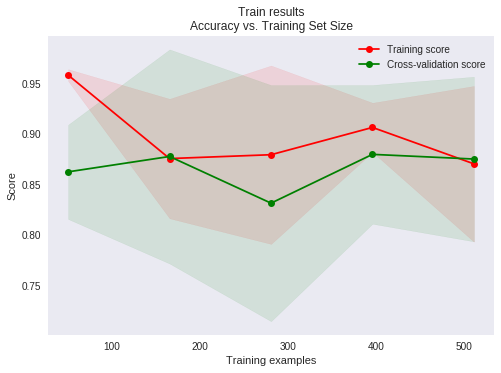

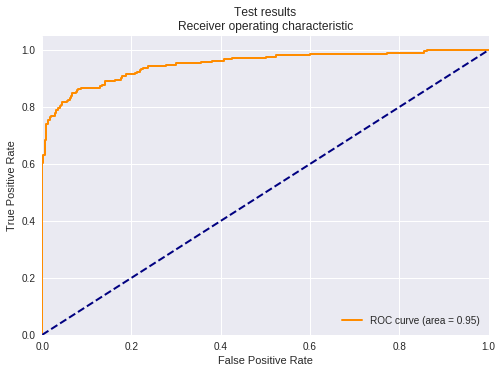

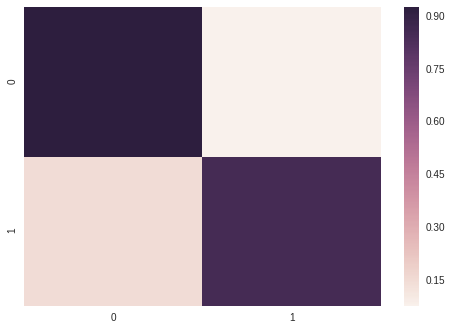

0.9502272607156069

In [40]:
data_feat = pd.read_csv(data_file, quotechar='"', sep=",", header=None).as_matrix()
X = data_feat[1:,2:31].astype(float)
    
# Build and train the classifier
skf = StratifiedKFold(n_splits=10, random_state=100)
X_tr_all, Y_tr_all, preds, preds_scores, test_gt, f1_folds, val_accuracy, clf = run_lr(X, Y, skf)
    
# Print the results
print_results(X, Y, preds, preds_scores, test_gt, f1_folds, val_accuracy, clf)